In [2]:
import graph_tool.all as gt
import numpy as np
from binance.client import Client
import pandas as pd
import ta as ta
from sklearn import preprocessing
from sklearn.manifold import SpectralEmbedding
from numpy.linalg import norm

In [3]:
#instantiating binance's API client object and requesting some data

client = Client("api key", "api secret")
fromdate = "10 Aug, 2019"
todate = "28 Dez, 2019"
symbol = "BTCUSDT"
kline_interval = "12h"
klines = client.get_historical_klines("BTCUSDT", kline_interval, fromdate)

period1 = 20


def format_klines(klines):
    OHLCV = []
    for k in klines:
        ohlcv = [float(k[1]), float(k[2]), float(k[3]), float(k[4]), float(k[5])]
        OHLCV.append(ohlcv)

    return OHLCV

OHLCV = format_klines(klines)
O = pd.Series([k[0] for k in OHLCV], name = "OPEN")
H = pd.Series([k[1] for k in OHLCV], name = "HIGH")
L = pd.Series([k[2] for k in OHLCV], name = "LOW")
C = pd.Series([k[3] for k in OHLCV], name = "CLOSE")
V = pd.Series([k[4] for k in OHLCV], name = "VOLUME")
R = pd.Series(C.values - O.values, name = "RETURNS")
X = [i for i in range(len(O))]

data_size = len(X)

In [6]:
#calculating some technical indicators to use as higher level properties

cr = ta.momentum.williams_r(H, L, C).fillna(method='backfill')
mfi = ta.volume.money_flow_index(H, L, C, V).fillna(method='backfill')
eom = ta.volume.ease_of_movement(H, L, C, V).fillna(method='backfill')
rsi = ta.momentum.rsi(C).fillna(method='backfill')
macd = ta.trend.macd_diff(C).fillna(method='backfill')

volatility = L.values / H.values
price_var = np.array([(close - open)/max([close,open]) for (close, open) in zip(C.values, O.values)])

In [7]:
spec_embed = SpectralEmbedding(n_components=2)
x = np.array([cr.values, mfi.values, eom.values, rsi.values, macd.values, volatility, price_var]).T
ex = spec_embed.fit_transform(x)
tx = preprocessing.quantile_transform(ex, n_quantiles=100)

In [83]:
price_var.min()

-0.2353709963224266

In [8]:
#instantiating the graph object and adding vertices

g=gt.Graph(directed=False)
g.add_vertex(data_size)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f8a1180c350>

In [77]:
#adding the acquired data to the vertices as properties

g.vp.closes = g.new_vp("float")
g.vp.closes.a = C.values
g.vp.volumes = g.new_vp("float")
g.vp.volumes.a = V.values
g.vp.volatility = g.new_vp("float")
g.vp.volatility.a = volatility
g.vp.price_var = g.new_vp("float")
g.vp.price_var.a = price_var
g.vp.pos_ = g.new_vp("vector<float>")
g.ep.distances = g.new_ep("float")
g.vp.color = g.new_vp("string")


In [78]:
#global parameters for the construction of the graph sequence with increasing spatial resolutions

N=data_size

#global init_foot, ibin


a=1
b=0 


init_foot = 0.01 #initial threshold distance step
ibin = 0.08 #initial threshold distance
fbin = 0.50 #final threshold distance

foot = (init_foot)*(10**a) #not being used, but we might want to vary the threshold distance step too
BIN = ibin - foot*b



step = 0.05  # move step for the layout update
K = 0.5

In [79]:
gg, gpos = gt.geometric_graph(tx, fbin)
gg.vp.pos = gpos

In [12]:
gu = gt.graph_union(gg, g, intersection=g.vertex_index, internal_props=True)

In [46]:
def set_distances(g):
    dists = []
    for e in g.edges():
        s, t = e
        pos_s = np.array(g.vp.pos[s])
        pos_t = np.array(g.vp.pos[t])
        distance = norm(pos_s - pos_t)
        # print(distance)
        dists.append(distance)
        g.ep.distances[e] = distance
    return dists

In [47]:
distances = set_distances(gu)

In [48]:
distances

[309.2827500262358,
 390.09233450894055,
 391.3116910636246,
 389.9485233683278,
 388.3174022194945,
 6.852957565809582,
 390.62931289579865,
 389.1098404013854,
 385.52087238737045,
 374.27550991641016,
 15.137263830321176,
 388.28388135880874,
 10.91442611190676,
 389.4890227896606,
 12.660121861275488,
 390.26611932834015,
 386.88849323679585,
 169.59992460606568,
 230.76726491620215,
 395.0272277030471,
 6.138684002270342,
 12.960673972200897,
 374.4425882953237,
 390.68479738718577,
 28.799473617370317,
 10.095499437613391,
 9.968632659029344,
 36.076184819450546,
 282.94549926813005,
 391.4815974126345,
 10.409070263516933,
 11.81518807972284,
 390.4190407036328,
 388.3762939487305,
 391.5133075815479,
 8.831927153051709,
 388.8028665005903,
 6.3351732404794205,
 389.84057298446567,
 396.3689102863425,
 16.31423953114618,
 16.03002261729994,
 375.84039595886617,
 386.9804628056652,
 16.377343550992553,
 373.0654006002181,
 394.5632825227491,
 12.285295034410156,
 3.74796661168384

In [49]:
gu.ep.distances.a

PropertyArray([233.72714376,  16.54914176,  37.7790579 , ...,
                18.94820354,  53.29094039, 365.67148406])

In [50]:
edge_filter = gu.new_ep("bool")
edge_filter.a = gu.ep.distances.a < ibin
gu.ep.edge_filter = edge_filter
gu.set_edge_filter(edge_filter)

In [51]:
gu.ep.edge_filter

<EdgePropertyMap object with value type 'bool', for Graph 0x7f8a11c14e80, at 0x7f8a0a9df4f0>

In [52]:
gu.vp.pos_ = gt.sfdp_layout(gu, vweight = gu.vp.volumes, K=0.5)

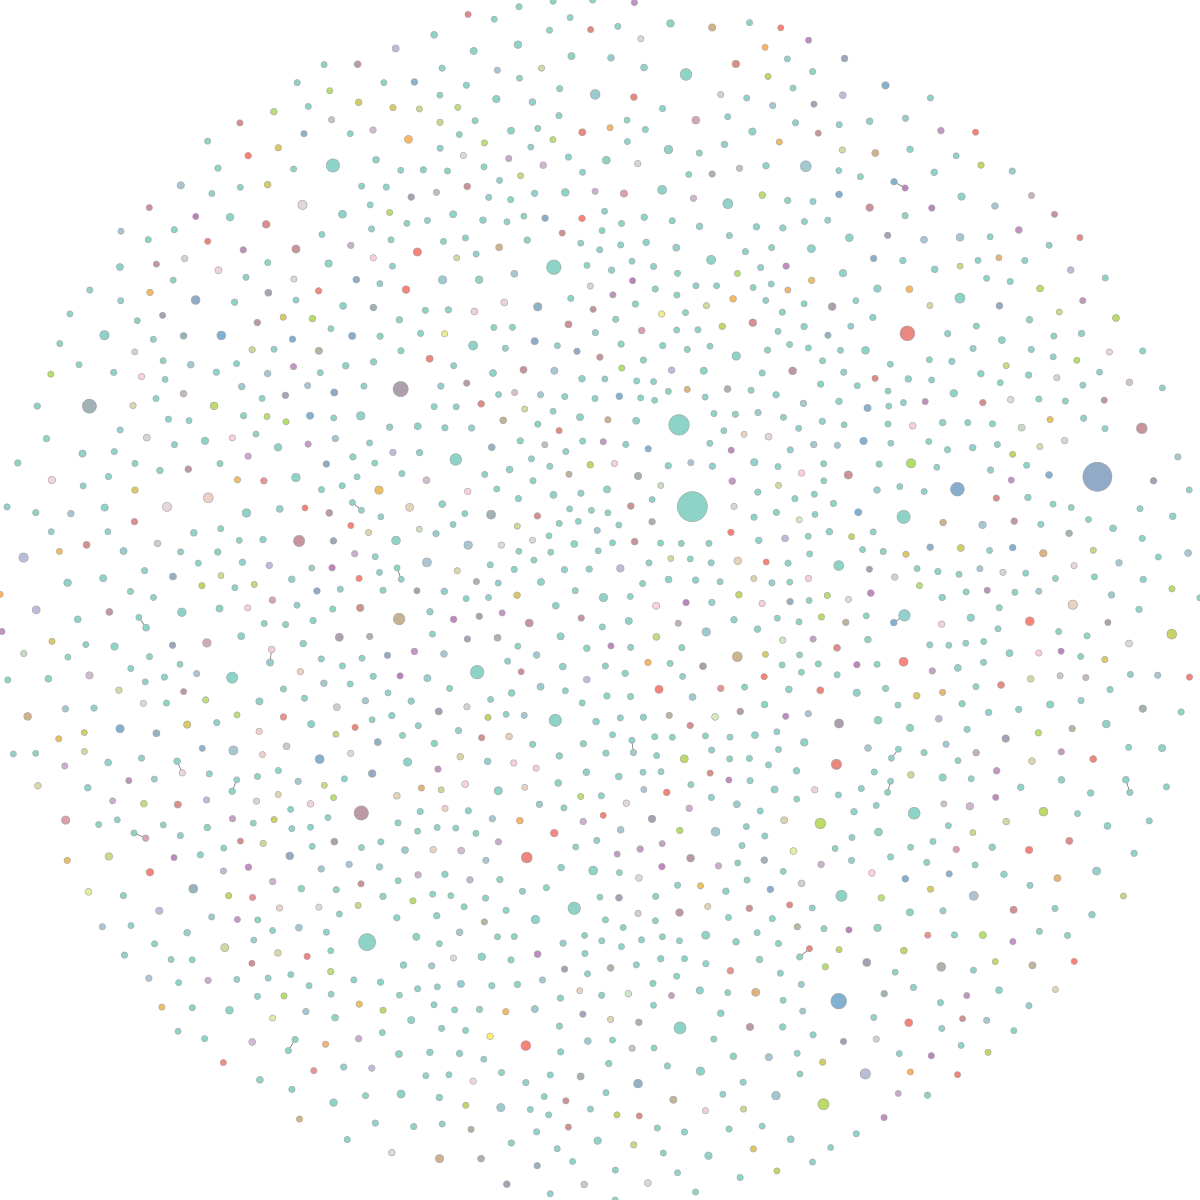

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8a11c14e80, at 0x7f8a118f0520>

In [53]:
gt.graph_draw(gu, pos=gu.vp.pos_,fit_view=1.00, vertex_fill_color=gt.prop_to_size(gu.vp.closes, mi=1, ma=1.5, log=False, power=2),vertex_size=gt.prop_to_size(gu.vp.volumes, mi=3, ma=15, log=False, power=2))

In [63]:
def make_graphs(gu, a, b):
    
    BIN = a

    while BIN <= b:

        gu.ep.edge_filter.a = gu.ep.distances.a < BIN
        gu.set_edge_filter(gu.ep.edge_filter)
        gu.vp.pos = gt.sfdp_layout(gu, pos=gu.vp.pos, K=K, init_step=step, max_iter=1)        

        BIN+=init_foot
        
        yield gu


In [71]:
def graph_sequence(g, ibin, init_foot, fbin, init_step, max_iter, K):

    dist_array = np.array(g.ep.distances.a)
    filter_array = dist_array <= ibin
    gv = gt.GraphView(g, efilt=filter_array)
    ng = gt.Graph(gv, prune=True)
    pos = gt.sfdp_layout(ng, pos=ng.vp.pos, K=K)
    ng.vp.pos = pos
    graphs = [ng]

    cbin = ibin + init_foot
    # pos = gt.sfdp_layout(g, pos=pos, K=1.5)
    while cbin <= fbin:
        filter_array = dist_array <= cbin
        gv = gt.GraphView(g, efilt=filter_array)
        ng = gt.Graph(gv, prune=True)
        ng.copy_property(graphs[-1].vp.pos, tgt=ng.vp.pos)
        # print(ng.num_edges())
        ng.vp.pos = gt.sfdp_layout(
            ng, pos=ng.vp.pos, max_iter=max_iter, init_step=init_step, K=K
        )
        graphs.append(ng)

        cbin += init_foot
        # step += init_foot * 3
    return graphs

In [72]:
graph_seq = graph_sequence(gu, ibin,init_foot, fbin, step, 1, K)

In [73]:
graph_seq

[<Graph object, undirected, with 1600 vertices and 15 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a0a9e1d30>,
 <Graph object, undirected, with 1600 vertices and 17 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8adb4c78e0>,
 <Graph object, undirected, with 1600 vertices and 21 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a11c12820>,
 <Graph object, undirected, with 1600 vertices and 25 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a0a9d4490>,
 <Graph object, undirected, with 1600 vertices and 28 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a118f0dc0>,
 <Graph object, undirected, with 1600 vertices and 32 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a11c12b50>,
 <Graph object, undirected, with 1600 vertices and 38 edges, 6 internal vertex properties, 2 internal edge properties, at 0x7f8a0a9da040>,
 <Graph object, undirected,

In [84]:
for i, gu in enumerate(graph_seq):
    gt.graph_draw(gu, pos=gu.vp.pos, vertex_fill_color=gt.prop_to_size(gu.vp.price_var, mi=1, ma=1.5, log=False, power=2), edge_pen_width=0.5, vertex_size=gt.prop_to_size(gu.vp.volumes, mi=3, ma=15, log=False, power=3), output="draw%i.png" %i)